## Package Installaion

In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install neuralprophet
%pip install matplotlib
%pip install seaborn
%pip install pickle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


## Package Importation

In [2]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict

import copy

import pickle

from sklearn.metrics import mean_squared_error
from math import sqrt

## Reading Data

Below we read in the data for train, val and test as well as the associated historical dataframe

In [3]:
IT_sector_historical = pd.read_csv('../data_processing/it_history.csv', index_col=0)

In [4]:
idx2col = {
    'index': 'ds',
    0: 'GEN',
    1: 'MSI',
    2: 'JKHY',
    3: 'APH',
    4: 'IBM',
    5: 'AKAM',
    6: 'MSFT',
    7: 'STX',
    8: 'AAPL',
    9: 'AMAT',
    10: 'TEL'
}

In [5]:
train = pd.read_csv('../data_processing/train_final.csv', index_col=0).T.reset_index(level=0).rename(columns=idx2col)
val = pd.read_csv('../data_processing/val_final.csv', index_col=0).T.iloc[1:,:].reset_index(level=0).rename(columns=idx2col)
test = pd.read_csv('../data_processing/test_final.csv', index_col=0).T.reset_index(level=0).rename(columns=idx2col)

In [6]:
earnings_10yr_df = pd.read_csv('../data_processing/earnings_10yr_past_future_df.csv')

## Auxiliary Plotting Functions

In [7]:
def plot_forecast(model, data, periods=0, historic_pred=True, highlight_steps_ahead=None, xlabel='Date', ylabel=None, title=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    fig, ax = plt.subplots(figsize=(14,10))

    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

    else:    
        model.plot(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

In [8]:
def plot_validation(metrics_df, metrics = ['SmoothL1Loss', 'MAE', 'RMSE']):
    met_len = len(metrics)

    fig, axs = plt.subplots(ncols=len(metrics), nrows=1, sharex=True, sharey=True, figsize=(8*met_len, 8))
    fig.suptitle('Validation Metrics', fontsize=20, y=0.95)

    if met_len == 1:
        metric = metrics[0]
        axs.plot(metrics_df[metric], 'ob', linewidth=6, label='Training Loss', markersize='3')
        axs.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='Validation Loss')

        axs.set_xlabel('Training Loss')
        axs.set_ylabel('Validation Loss')
        axs.set_title(metric)
        axs.legend()
    else:
        for metric, ax in zip(metrics, axs.ravel()):
            ax.plot(metrics_df[metric], 'ob', linewidth=6, label='Training Loss', markersize='3')
            ax.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='Validation Loss')

            ax.set_xlabel('Training Loss')
            ax.set_ylabel('Validation Loss')
            ax.set_title(metric)
            ax.legend()

## Base Model (Train)
---

Below we define the base model alongside the addition of country holidays in the US. This acts as the 'base model' with which we will conduct the analysis of the additive events futher:

In [9]:
base_model = NeuralProphet(
    growth='discontinuous',  # Determine trend types: ‘linear’, ‘discontinuous’, ‘off’
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=4, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=0.01, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize=‘auto’,  # Type of normalization (‘minmax’, ‘standardize’, ‘soft’, ‘auto’, None) ## Why normalize again?
    )
base_model.add_country_holidays('US')

## Additive Events

In [10]:
CES_dates_df = pd.DataFrame(
    {
        "event": "CES Show",
        "ds": pd.to_datetime(
            [
                "2012-01-11",
                "2013-01-10",
                "2013-01-09",
                "2014-01-05",
                "2015-01-09",
                "2016-01-07",
                "2017-01-06",
                "2018-01-10",
                "2019-01-09",
                "2020-01-08",
                "2021-01-12",
                "2022-01-05",
                "2023-01-06",
            ]
        ),
    }
)

AAPL_dates_df = pd.DataFrame(
    {
        "event": "AAPL Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['aapl']
        ),
    }
)

META_dates_df = pd.DataFrame(
    {
        "event": "META Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['meta']
        ),
    }
)

GOOG_dates_df = pd.DataFrame(
    {
        "event": "GOOG Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['goog']
        ),
    }
)

NFLX_dates_df = pd.DataFrame(
    {
        "event": "NFLX Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['nflx']
        ),
    }
)

AMZN_dates_df = pd.DataFrame(
    {
        "event": "AMZN Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['amzn']
        ),
    }
)

MSFT_dates_df = pd.DataFrame(
    {
        "event": "MSFT Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['msft']
        ),
    }
)

NVDA_dates_df = pd.DataFrame(
    {
        "event": "NVDA Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['nvda']
        ),
    }
)

AMD_dates_df = pd.DataFrame(
    {
        "event": "AMD Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['amd']
        ),
    }
)

INTC_dates_df = pd.DataFrame(
    {
        "event": "INTC Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['intc']
        ),
    }
)

### Create Events Dataframe for IT Sector

In [11]:
event_names = [
    'CES Show',
    'AAPL Earnings', 
    'META Earnings', 
    'GOOG Earnings', 
    'NFLX Earnings', 
    'AMZN Earnings',
    'MSFT Earnings',
    'NVDA Earnings',
    'AMD Earnings',
    'INTC Earnings',
]

In [12]:
events_df = pd.concat(
    (
        CES_dates_df,
        AAPL_dates_df,
        META_dates_df,
        GOOG_dates_df,
        NFLX_dates_df,
        AMZN_dates_df,
        MSFT_dates_df,
        NVDA_dates_df,
        AMD_dates_df,
        INTC_dates_df
    ),
)

In [13]:
events_df

,event,ds
0,CES Show,2012-01-11
1,CES Show,2013-01-10
2,CES Show,2013-01-09
3,CES Show,2014-01-05
4,CES Show,2015-01-09
...,...,...
43,INTC Earnings,2013-01-17
44,INTC Earnings,2012-10-16
45,INTC Earnings,2012-07-17
46,INTC Earnings,2012-04-17


In [15]:
read_in_models_and_files = False

models_dict = dict()

for symbol in train.columns:
    if symbol == 'ds': continue

    if read_in_models_and_files:
        with open(f'./complete_files/model_pickles/{symbol}_model.pkl', 'rb') as f:
            model = pickle.load(f)
        with open(f'./complete_files/model_metrics/{symbol}_metrics.csv', 'rb') as f:
            metrics = pd.read_csv(f)
        with open(f'./complete_files/model_historical_train_df/{symbol}_historical_train_df.csv', 'rb') as f:
            historical_train_df = pd.read_csv(f)
        with open(f'./complete_files/model_historical_val_df/{symbol}_historical_val_df.csv', 'rb') as f:
            historical_val_df = pd.read_csv(f)
        models_dict[symbol] = [model, metrics, historical_train_df, historical_val_df]
        
    else:
        model = copy.deepcopy(base_model)
        model = model.add_events(event_names, lower_window=-1, upper_window=1)

        train_with_dates_df = train[[symbol, 'ds']].rename(columns={symbol: 'y'})
        val_with_dates_df = val[[symbol, 'ds']].rename(columns={symbol: 'y'})

        historical_train_df = model.create_df_with_events(train_with_dates_df, events_df)
        historical_val_df = model.create_df_with_events(val_with_dates_df, events_df)

        metrics = model.fit(
            df=historical_train_df,
            freq='D',
            validation_df=historical_val_df,
            progress='bar'
        )

        pickle.dump(model, open(f'./complete_files/model_pickles/{symbol}_model.pickle', 'wb'))
        historical_train_df.to_csv(open(f'./complete_files/model_historical_train_df/{symbol}_historical_val_df.csv', 'wb'))
        historical_val_df.to_csv(open(f'./complete_files/model_historical_val_df/{symbol}_historical_val_df.csv', 'wb'))
        pickle.dump(metrics, open(f'./complete_files/model_metrics/{symbol}_metrics.csv', 'wb'))
        
        models_dict[symbol] = [model, metrics, historical_train_df, historical_val_df]
        pickle.dump(models_dict, open('./complete_files/model_pickles/models_dict.pickle', 'wb'))
    

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/df_utils.py:389: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/df_utils.py:389: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/p

## Creating & Predicting Into Future
---

Note with the above `models_dict`, the storage of each `Symbol`'s data are as follows in a `dict` format:

`model = 0`

`metrics = 1`

`historical_train_df = 2`

`historical_val_df = 3`

Below we show one example of a company "JKHY" and plotting the outputs associated

In [16]:
model = models_dict['JKHY'][0]
metrics = models_dict['JKHY'][1]
historical_train_df = models_dict['JKHY'][2]
historical_val_df = models_dict['JKHY'][3]

In [17]:
future = model.make_future_dataframe(df=historical_train_df, events_df=events_df, periods=365, n_historic_predictions=len(train))
forecast = model.predict(df=future)

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/df_utils.py:806: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

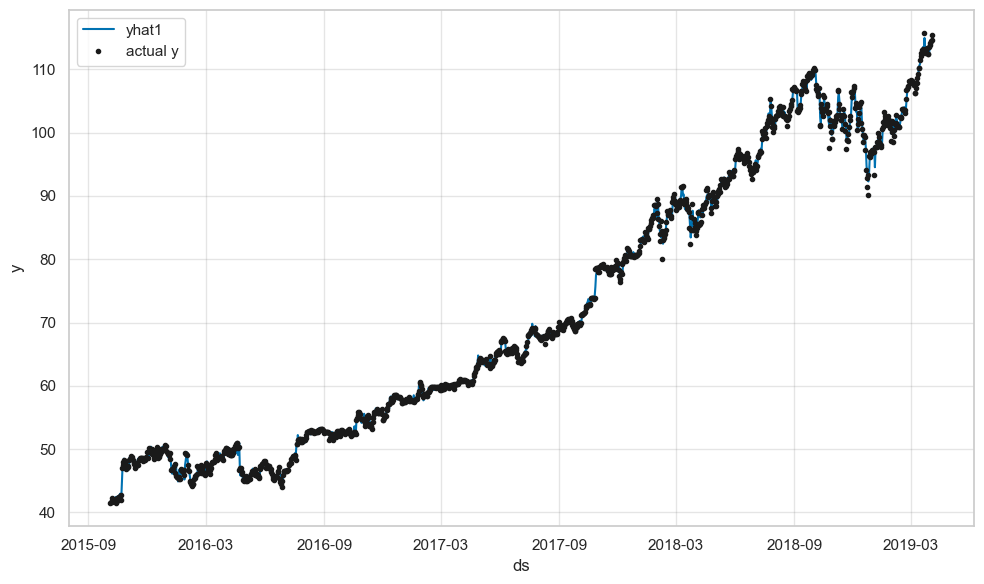

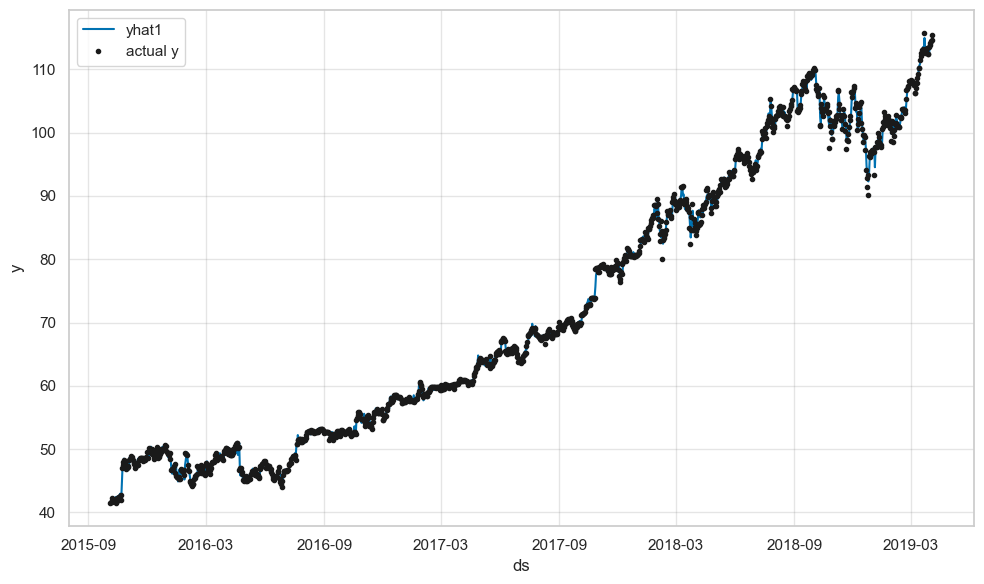

In [18]:
model.plot(forecast)

## Plotting Subplots of Additive-Events
---

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/df_utils.py:806: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - /Users/sunnyson/opt/anaconda3/envs/pTSA/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

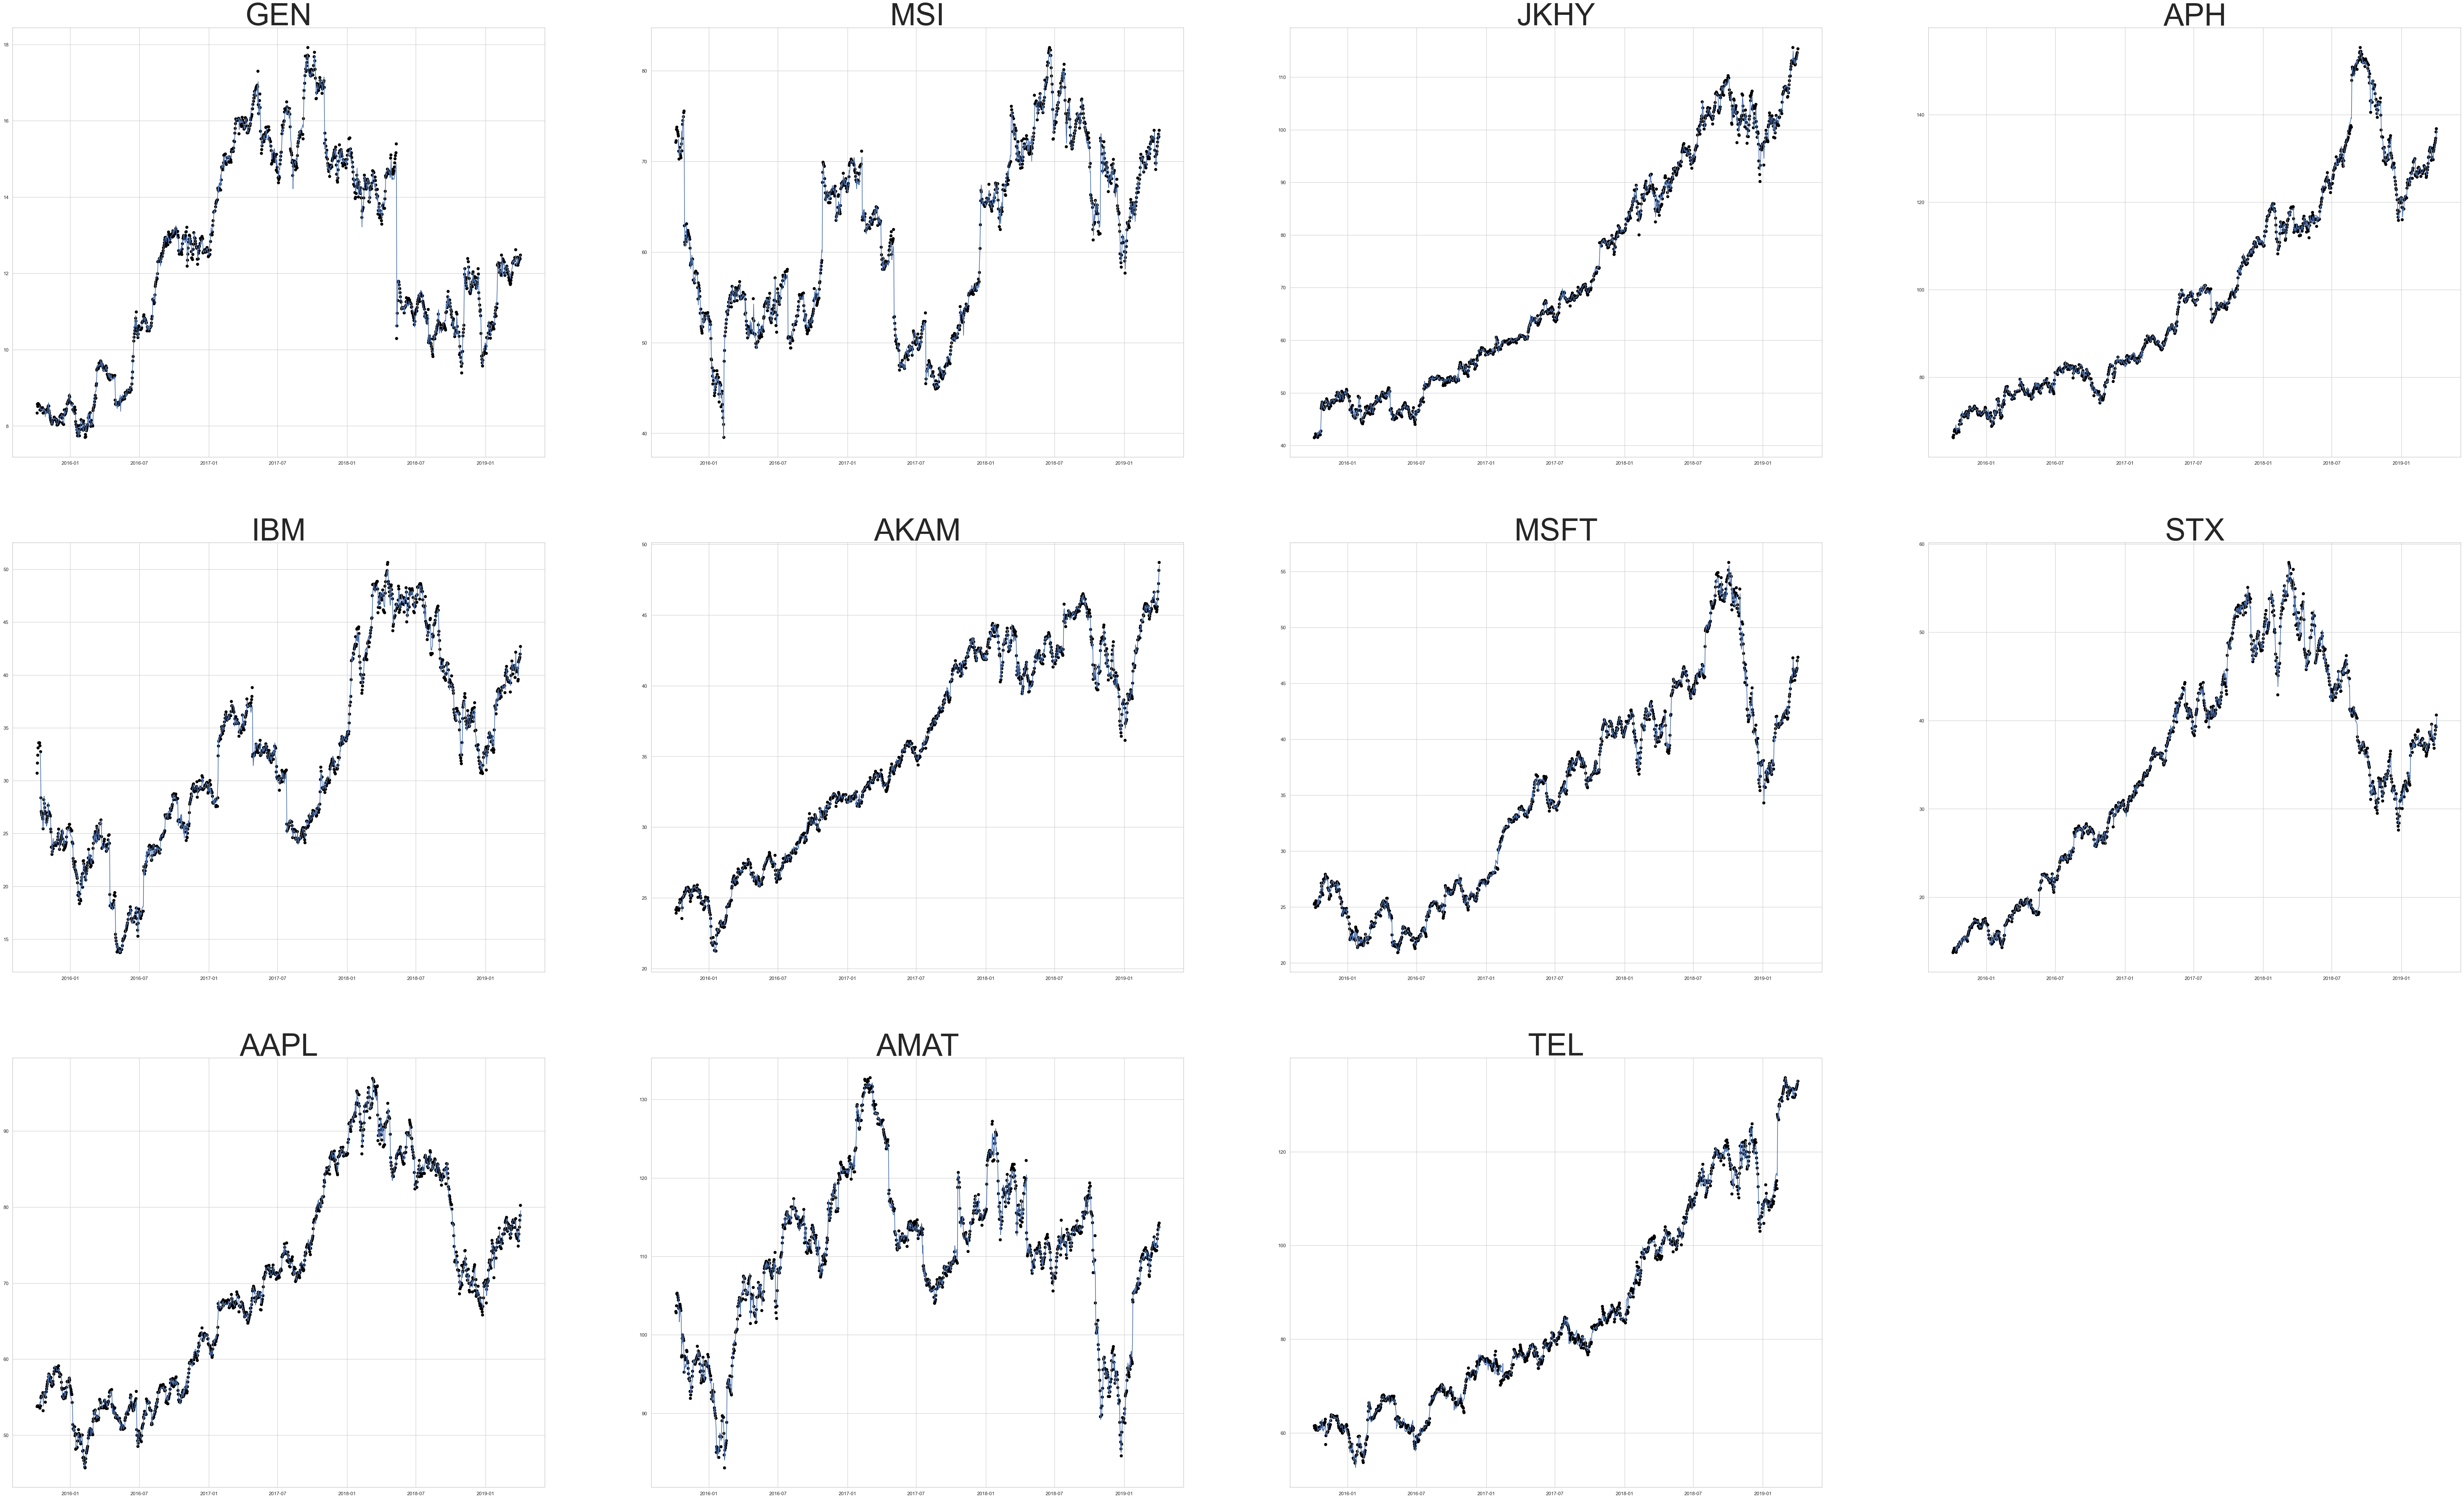

In [38]:
save_MAE_RMSE = True
fig, axs = plt.subplots(3, 4, figsize = (100,60))

RMSE_MAE_dict = {}
for i, ax in zip(range(12), axs.flatten()):
    if i == 11: 
        ax.axis('off')
        continue
    symbol = idx2col[i]
    
    model = models_dict[symbol][0]
    metrics = models_dict[symbol][1]
    historical_train_df = models_dict[symbol][2]
    historical_val_df = models_dict[symbol][3]
    
    future = model.make_future_dataframe(df=historical_train_df, events_df=events_df, periods=365, n_historic_predictions=len(train))
    forecast = model.predict(df=future)

    valid_forecast = forecast[~forecast.isnull().any(axis=1)]['residual1']
    
    MAE = np.abs(valid_forecast).sum()/len(valid_forecast)
    RMSE = np.sqrt(np.square(valid_forecast).sum()/len(valid_forecast))
    
    RMSE_MAE_dict[symbol] = [RMSE, MAE]
    
    ax.scatter(forecast['ds'],forecast['y'], c = 'black')
    ax.plot(forecast['ds'],forecast['yhat1'])
    ax.set_title(symbol, size=70)

if save_MAE_RMSE: pickle.dump(RMSE_MAE_dict, open('./additive_files/models_dict/RMSE_MAE_dict.pickle', 'wb'))
    
plt.show()

## RMSE
---

Below we define a function to determine the RMSE of each trained model

In [39]:
RMSE_MAE_dict

{'GEN': [0.1877168619382209, 0.10390913868200742],
 'MSI': [0.8940206539110275, 0.545484114319008],
 'JKHY': [0.7658125577734468, 0.5098653102484274],
 'APH': [0.8382526928383257, 0.5797774227272493],
 'IBM': [0.5667906469948091, 0.37896343366367613],
 'AKAM': [0.29152206814126985, 0.2087513508133374],
 'MSFT': [0.40692503094201266, 0.2725029629985178],
 'STX': [0.5486405046155816, 0.3630240426601701],
 'AAPL': [0.6447116923210575, 0.4521781846294251],
 'AMAT': [0.9389690995888147, 0.612176750964067],
 'TEL': [1.0815423818777874, 0.7707902683047794]}

In [40]:
metrics

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.753243,80.774015,98.777358,0.0,1.486597,133.917969,155.555313
1,0.719521,78.250141,95.493588,0.0,1.363358,124.590889,146.506714
2,0.696808,76.441404,93.473166,0.0,1.262844,117.154388,138.876892
3,0.678365,74.973152,91.408595,0.0,1.210655,113.424446,134.727448
4,0.657925,73.406182,89.877189,0.0,1.157109,109.602669,130.337845
...,...,...,...,...,...,...,...
175,0.000124,0.774266,1.042976,0.0,0.024147,13.503134,15.134086
176,0.000124,0.771900,1.042119,0.0,0.024151,13.502762,15.135165
177,0.000123,0.770687,1.045033,0.0,0.024158,13.505627,15.137429
178,0.000123,0.770789,1.041636,0.0,0.024166,13.508503,15.140023


In [37]:
134.157166-134.390244

-0.2330780000000061

In [36]:
forecast

,ds,y,yhat1,residual1,ar1,trend,season_yearly,season_weekly,events_additive,event_AAPL Earnings,...,event_Martin Luther King Jr. Day,event_Memorial Day,event_NFLX Earnings,event_NVDA Earnings,event_New Year's Day,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday
0,2015-10-05,61.552830,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2015-10-06,61.058628,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2015-10-07,61.588116,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2015-10-08,61.332199,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2015-10-09,60.696812,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,2019-03-31,133.872365,134.053619,0.181254,70.43232,65.088837,-1.401212,-0.066314,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1274,2019-04-01,134.157166,134.390244,0.233078,70.763321,65.156158,-1.433605,-0.095643,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275,2019-04-02,134.489441,134.861023,0.371582,70.994934,65.223495,-1.463708,0.106298,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1276,2019-04-03,135.078003,135.014725,-0.063278,71.247063,65.290817,-1.491636,-0.031527,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
rmse_dict = {}
for i in range(11):
    symbol = idx2col[i]
    
    model = models_dict[symbol][0]
    metrics = models_dict[symbol][1]
    historical_train_df = models_dict[symbol][2]
    historical_val_df = models_dict[symbol][3]
    
    
    
for i, ax in zip(range(12), axs.flatten()):
    if i == 11: 
        ax.axis('off')
        continue
    symbol = idx2col[i]
    
    model = models_dict[symbol][0]
    metrics = models_dict[symbol][1]
    historical_train_df = models_dict[symbol][2]
    historical_val_df = models_dict[symbol][3]
    
    future = model.make_future_dataframe(df=historical_train_df, events_df=events_df, periods=365, n_historic_predictions=len(train))
    forecast = model.predict(df=future)
    
    ax.scatter(forecast['ds'],forecast['y'], c = 'black')
    ax.plot(forecast['ds'],forecast['yhat1'])
    ax.set_title(symbol, size=70)

## Deprecated Code with Multiple Industries

In [ ]:
has_historical_df = False
read_in_model_and_metrics = False
model_dict = defaultdict()

for industry, symbols in industry_to_symbol_map.items():
    model_dict[industry] = defaultdict()
    for symbol in symbols:
        model_dict[industry][symbol] = {
            'model': None,
            'metrics': None,
        }

        if read_in_model_and_metrics:
            model_dict[industry][symbol]['model'] = pickle.load('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/model.pkl')
            model_dict[industry][symbol]['metrics'] = pickle.load('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/metrics.pkl')
        else:
            model = base_model
            # model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1)
            model = model.add_events(additive_events[industry])

            ## Reads in historical_df if has_historical_df else creates & writes historical_df
            if has_historical_df:
                historical_df = pd.read_csv('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/historical_df.csv')
            else:
                historical_df = model.create_df_with_events(train[:, symbol_to_index_map[symbol]], additive_events[industry])
                historical_df.to_csv('./model/' + industry_to_folder_map[industry] + '/' + symbol + '/historical_df.csv', index=False)
            
            metrics = model.fit(historical_df, freq="D", validation_df=val[symbol_to_index_map[symbol]])
            
            ## Updating defaultdict of mdoels
            model_dict[industry][symbol]['model'] = model
            model_dict[industry][symbol]['metrics'] = metrics

            ## Pickling model and metrics
            model_path = './model/' + industry_to_folder_map[industry] + '/' + symbol + '/model'
            metrics_path = './model/' + industry_to_folder_map[industry] + '/' + symbol + '/metrics'

            pickle.dump(model, model_path)
            pickle.dump(metrics, metrics_path)